In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value

In [2]:
sampling_interval = 60
sample_offsets = np.arange(0, (ssn_end - goldstone_end)/(1*u.s), sampling_interval)
flyby_epochs = goldstone_end + (sample_offsets << u.s)
print("Start and end epochs:", goldstone_end, flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 06:14:55.600 1998-01-23 06:53:55.600 [ 40 ]


In [3]:
near_goldstone_end_rv = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_goldstone_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 31115.055593836172 km 13950.138983094505 km
Start and end radial speeds: -7.684513660227914 km / s -6.842604822897599 km / s
Closest: 13950.138983094505 km speed 9.481442321702268 km / s  at  1998-01-23 06:53:55.600
Deflection: 3.3977346186225956 deg


In [5]:
altair_residuals = []
millstone_residuals = []

for o in sample_offsets:
    e = goldstone_end + o*u.s

    ref_r, ref_rr = ssrAltair.range_and_rate(near_goldstone_ephem.rv(e), e)
    altair_residuals.append((ref_rr*ref_r/const.c).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(near_goldstone_ephem.rv(e), e)
    millstone_residuals.append((ref_rr*ref_r/const.c).to_value(u.m))

In [6]:
print(altair_residuals)
print(millstone_residuals)

[-927.283345399693, -914.2201703397902, -901.1249030179771, -887.9965346613802, -874.8340093928158, -861.6362214504505, -848.4020122049038, -835.1301669564757, -821.819411493529, -808.4684083911786, -795.0757530274462, -781.6399692917795, -768.1595049583646, -754.632726693943, -741.0579146668236, -727.4332567204957, -713.7568420715874, -700.0266544879515, -686.2405648982833, -672.3963233798987, -658.4915504661465, -644.5237277093202, -630.4901874289162, -616.3881015686925, -602.2144695792701, -587.9661052360127, -573.6396222949132, -559.2314188823141, -544.7376605078911, -530.1542615849797, -515.4768653386615, -500.7008219811627, -485.8211650374257, -470.8325857131917, -455.7294052164002, -440.5055449739356, -425.15449473508556, -409.6692786277584, -394.0424193436239, -378.26590078760427]
[-859.9372615917123, -849.076463615855, -838.1883978668794, -827.2721266200575, -816.3266711245266, -805.3510091294256, -794.3440722230991, -783.3047429685254, -772.2318518163869, -761.1241737752321, 

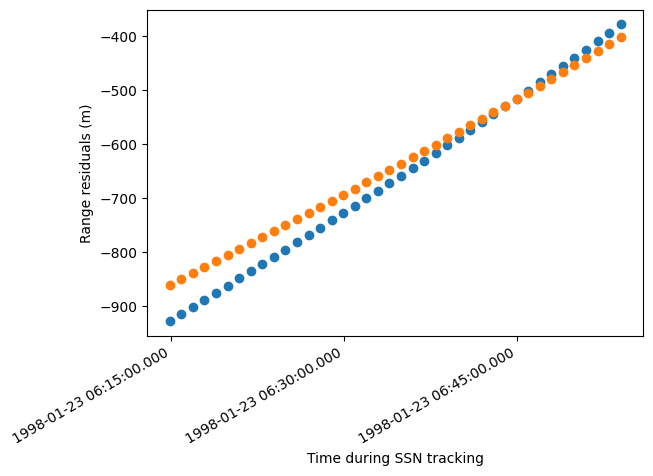

In [7]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Time during SSN tracking')
    plt.ylabel('Range residuals (m)')
    plt.scatter(flyby_epochs, altair_residuals)
    plt.scatter(flyby_epochs, millstone_residuals)
    plt.gcf().autofmt_xdate()